In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Mon Jan 22 22:08:22 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   43C    P0    46W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_randn_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = True
hp.quantize = False
hp.prior_mu = 0.9999

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 648776
-rw-rw-r-- 1 scpark scpark     49582  1월 22 22:08 events.out.tfevents.1705928352.GPUSVR11
-rw-rw-r-- 1 scpark scpark   7470716  1월 22 22:06 save_0
-rw-rw-r-- 1 scpark scpark    436327  1월 22 02:14 events.out.tfevents.1705856282.GPUSVR11
-rw-rw-r-- 1 scpark scpark    741007  1월 20 19:40 events.out.tfevents.1705745732.GPUSVR11
-rw-rw-r-- 1 scpark scpark    226318  1월 20 19:15 events.out.tfevents.1705745291.GPUSVR11
-rw-rw-r-- 1 scpark scpark     11372  1월 20 19:08 events.out.tfevents.1705745202.GPUSVR11
-rw-rw-r-- 1 scpark scpark        40  1월 20 19:06 events.out.tfevents.1705742695.GPUSVR11
-rw-rw-r-- 1 scpark scpark   1214325  1월 20 19:06 events.out.tfevents.1705742758.GPUSVR11
-rw-rw-r-- 1 scpark scpark       624  1월 20 18:27 events.out.tfevents.1705742700.GPUSVR11
-rw-rw-r-- 1 scpark scpark        40  1월 20 18:22 events.out.tfevents.1705736906.GPUSVR11
-rw-rw-r-- 1 scpark scpark   2890170  1월 20 18:22 events.out.tfevents.1705736910.GPUSVR11
-rw-rw-r-- 1 scpark scpark   7

### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

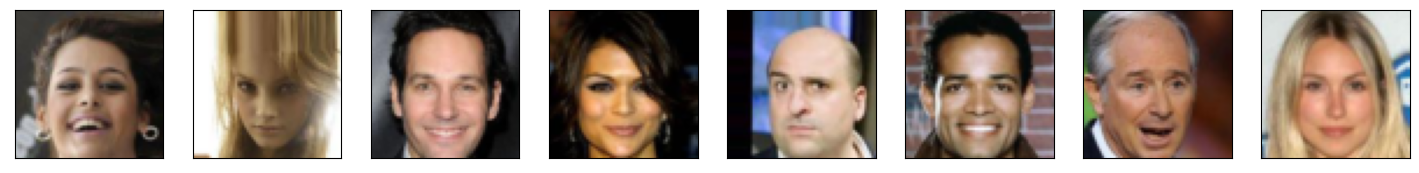

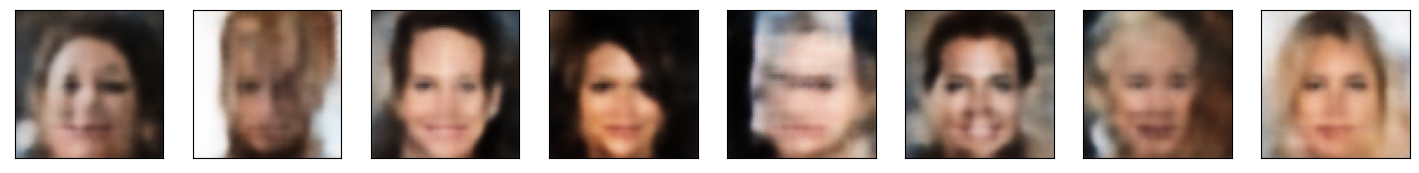

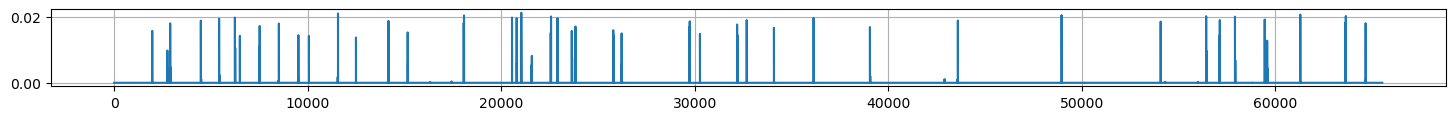

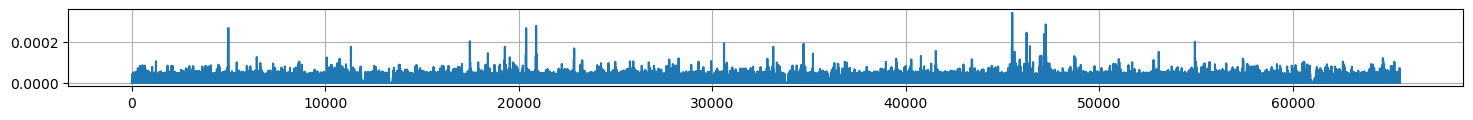

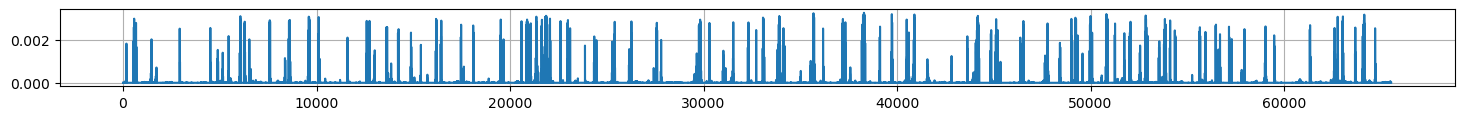

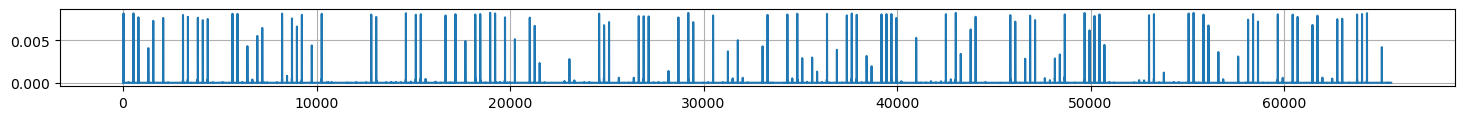

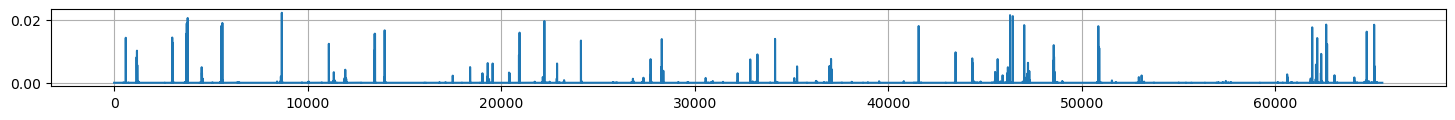

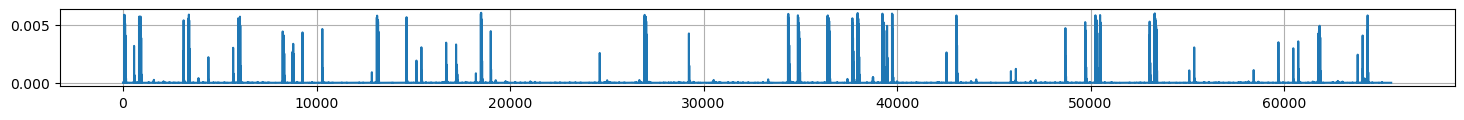

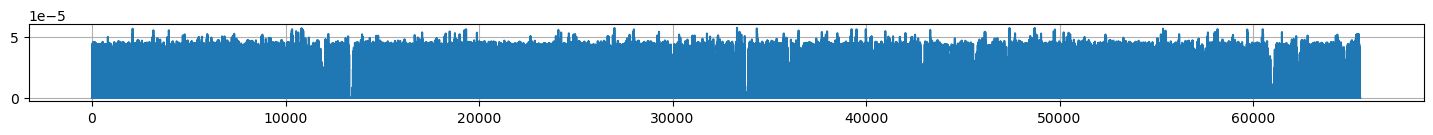

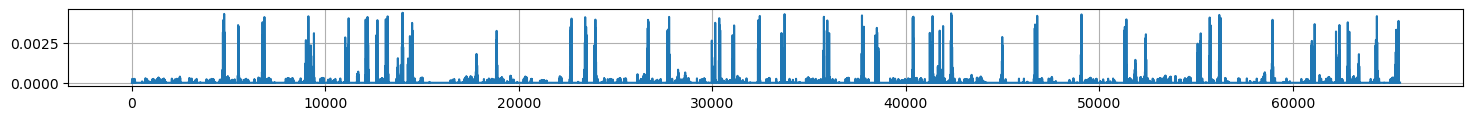

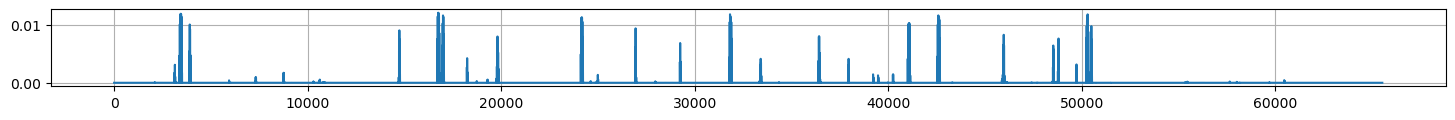

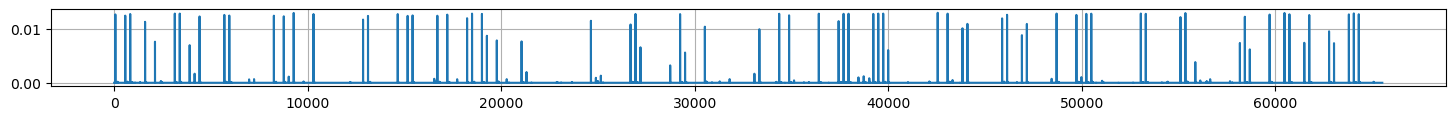

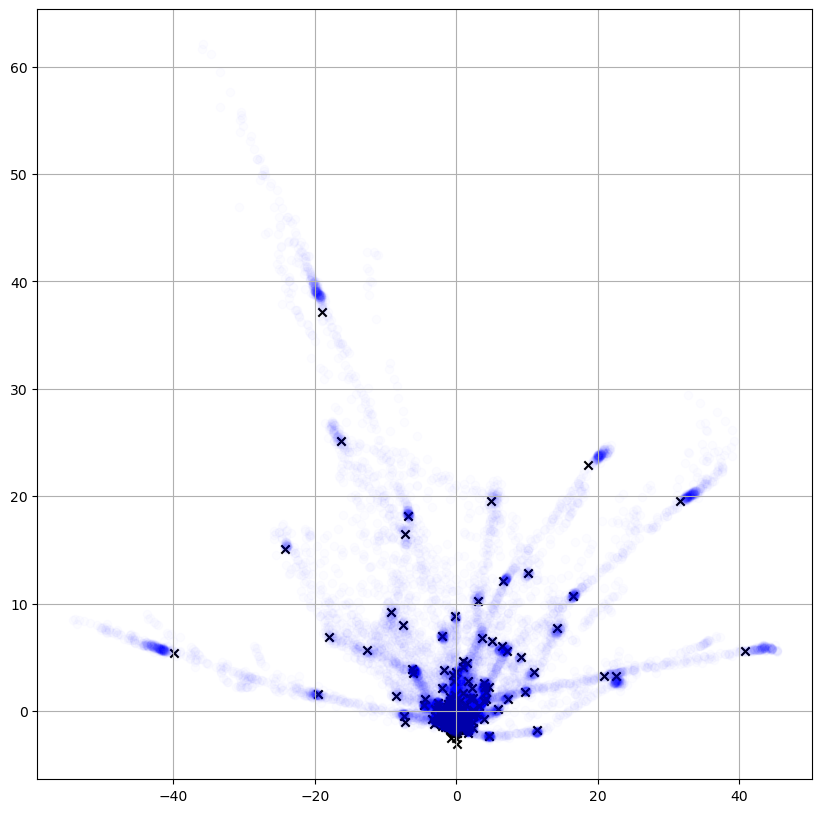

16001
lse_loss -26.160316467285156
commit_loss 0.039569541811943054
recon_loss 0.007638284470885992
16002
lse_loss -26.17206573486328
commit_loss 0.0388050451874733
recon_loss 0.007881457917392254
16003
lse_loss -26.170257568359375
commit_loss 0.043675437569618225
recon_loss 0.007678478956222534
16004
lse_loss -26.171142578125
commit_loss 0.0437626875936985
recon_loss 0.007894700393080711
16005
lse_loss -26.174156188964844
commit_loss 0.04082460701465607
recon_loss 0.007672553416341543
16006
lse_loss -26.163490295410156
commit_loss 0.03909403085708618
recon_loss 0.007722657173871994
16007
lse_loss -26.164451599121094
commit_loss 0.036823466420173645
recon_loss 0.007457343395799398
16008
lse_loss -26.171855926513672
commit_loss 0.038758572190999985
recon_loss 0.008074214681982994
16009
lse_loss -26.171077728271484
commit_loss 0.03873236104846001
recon_loss 0.0074545531533658504
16010
lse_loss -26.164897918701172
commit_loss 0.04266563802957535
recon_loss 0.007625266909599304
16011
lse_l

16085
lse_loss -26.186843872070312
commit_loss 0.03869427740573883
recon_loss 0.007440074346959591
16086
lse_loss -26.18183135986328
commit_loss 0.040372151881456375
recon_loss 0.007949787192046642
16087
lse_loss -26.17990493774414
commit_loss 0.045128997415304184
recon_loss 0.00767972506582737
16088
lse_loss -26.175193786621094
commit_loss 0.03799823299050331
recon_loss 0.007988042198121548
16089
lse_loss -26.186809539794922
commit_loss 0.04127929359674454
recon_loss 0.007770923897624016
16090
lse_loss -26.170249938964844
commit_loss 0.0418759286403656
recon_loss 0.008057070896029472
16091
lse_loss -26.177474975585938
commit_loss 0.04128438979387283
recon_loss 0.007589699700474739
16092
lse_loss -26.18883514404297
commit_loss 0.03753751888871193
recon_loss 0.007294178009033203
16093
lse_loss -26.176368713378906
commit_loss 0.038092225790023804
recon_loss 0.007464464753866196
16094
lse_loss -26.183578491210938
commit_loss 0.03699258714914322
recon_loss 0.007295563817024231
16095
lse_lo

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')